In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from celluloid import Camera
from matplotlib.backend_bases import FigureCanvasBase
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import timeit
from tqdm import tqdm
import pandas as pd

from src.environment_old import LogEnv_old
from src.utils import path_distance_new, check_missing_vertexes_jampr, create_dataset

from src.or_functions import compute_distance

#from src.environment import LogEnv
#from src.train import train
#from src.architecture import AttentionModel
#from src.evaluation import compute_mean_metric, compute_data_metric, compute_mean_metric_with_or
#from src.vizualisation import demonstration, action_animation
from src.environment_real import LogEnv
from src.architecture import AttentionModel
from src.train import train
from src.or_functions import compute_distance
from src.evaluation import compute_mean_metric, compute_mean_metric_with_or, compute_metric_on_data,\
    compute_metric_on_data_without_or
from src.vizualisation import demonstration, env_plot

import GPUtil
from pytorch_memlab import LineProfiler, MemReporter

In [3]:
with open('loc_distance_islands.pkl', 'rb') as f:
    r = pickle.load(f)

## Отладка

In [ ]:
env = LogEnv(n=20, batch_size=2, active_num=1, K=5)
env.reset()
'a'

In [ ]:
model = AttentionModel(active_num=1).to('cuda')
#model.eval()
'a'
#model.load_state_dict(weights)

In [ ]:
r

In [ ]:
r2

In [ ]:
v[0][0], v[0][1]

In [ ]:
v

In [ ]:
features, d, mask = env.reset(full_reset=False)

print(features)
print(mask)
flag = False
while not flag:
    v1 = int(input())
    v2 = int(input())
    v = torch.tensor([v1, v2]).view(1, -1)
    v1 = int(input())
    v2 = int(input())
    v_m = torch.tensor([v1, v2]).view(1, -1)
    v = torch.cat([v, v_m], dim=0)
    print(v)
    print(mask[0, v[0][1]], mask[1, v[1][1]])
    features, mask, flag = env.step(v)
    print(features[1][:, :, -1])
    features = list(map(lambda x: x.to('cuda'), features))
    print(mask)
    print(flag)
print(env.tour_plan)

#18, 19, 17, 3, 8, 9, 5, 13, 2, 15, 1, 21
#12, 10, 4, 7, 14, 16, 11, 6, 20, 21

#16, 6, 8, 4, 18, 13, 12, 21
#1, 2, 14, 7, 11, 19, 15, 20, 17, 10, 5, 3, 9, 21

In [ ]:
d[1][4, 18]/720

In [ ]:
print(features[2][:, :, 4].sum().to('cpu') + check_missing_vertexes_jampr(env.tour_plan, problem_size) * 10000)

#20 -> 13 -> 2 -> 16 -> 18 -> 15 -> 14 -> 3
#9 -> 1 -> 17 -> 10 -> 7 -> 8
#19 -> 12 -> 5 -> 11 -> 6 -> 4


#17 -> 9 -> 7 -> 1 -> 19 -> 12 -> 11 -> 6
#13 -> 3
#2 -> 15
#20 -> 5 -> 4 -> 14
#10 -> 8 -> 16 -> 18

In [ ]:
features, _, mask = env.reset(full_reset=True)

In [ ]:
# print(mask)
features, _, mask = env.reset(full_reset=False)
print(features[0][:, :, 3:5])
print(features[0][:, :, 2])
flag = False
while not flag:
    v1 = int(input())
    v2 = int(input())
    v = torch.tensor([v1, v2]).view(1, -1)
    print(v)
    #print(d[0, v[0, 1], :])
    features_new, mask, flag = env.step(v)
    features_new = list(map(lambda x: x.to('cuda'), features_new))
    print(features_new[1][:, :, -1])
    print(mask)
    print(flag)
print(env.tour_plan)
print(env.vehicle[:, :, 4].sum().to('cpu') + check_missing_vertexes_jampr(env.tour_plan, 20))

#4 -> 3 -> 14 -> 17 -> 7 -> 16 -> 21
#8 -> 20 -> 1 -> 12 -> 2 -> 11-> 21 
#5 -> 13 -> 21
#9 -> 10 -> 15 -> 6 -> 19 -> 18 -> 21

In [ ]:
device = 'cuda'

In [ ]:
problem_size = 50

In [ ]:
#env = LogEnv(n=10, batch_size=1, active_num=1)
features, d, mask = env.reset(full_reset=True)
print(d)
#print(mask)
#print(env.pairs)
print(features[0][:, :, 3:5])
print(features[0][:, :, 2])
flag = False
t = 0
precomputed = None
features[0] = features[0].to(device)
features[1] = features[1].to(device)
flag_done = False
t = 0
precomputed = None
while not flag_done:
    v, _, precomputed = model(features, mask, t, precomputed, False)
    v = v.to('cpu')
    with torch.no_grad():
        print(env.fillness, features[1][:, :, -1])
        features, mask, flag_done = env.step(v)
        features[1] = features[1].to(device)
    t += 1
    #print(flag)
    #print(mask)
print(features[1][:, :, -1])
print(env.tour_plan)

In [ ]:
check_missing_vertexes_jampr(env.tour_plan, 10)


In [ ]:
print(env.vehicle[:, :, 4].sum().to('cpu') + check_missing_vertexes_jampr(env.tour_plan, 10))


#20 -> 13 -> 2 -> 16 -> 18 -> 15 -> 14 -> 3
#9 -> 1 -> 17 -> 10 -> 7 -> 8
#19 -> 12 -> 5 -> 11 -> 6 -> 4

In [ ]:
print(env.vehicle[:, :, 4])

In [ ]:
features, _, mask = env.reset(full_reset=False)

In [ ]:
print(env.tour_plan)

In [ ]:
data = {}
data['time_matrix'] = env.distance.numpy()[0].squeeze()
data['num_vehicles'] = 5
data['time_windows'] = env.tw.numpy()[0].squeeze()
data['demands'] = env.demand.numpy()[0].squeeze()*env.capacity
data['vehicle_capacities'] = [env.capacity]*data['num_vehicles']
data['starts'] = [0]*data['num_vehicles']
data['ends'] = [21]*data['num_vehicles']

In [ ]:
m, r = compute_distance(data, eps=1e-2, time_limit=30)

In [ ]:
data = {}
data['time_matrix'] = env.distance.numpy()[1].squeeze()
data['num_vehicles'] = 5
data['time_windows'] = env.tw.numpy()[1].squeeze()
data['demands'] = env.demand.numpy()[1].squeeze()*env.capacity
data['vehicle_capacities'] = [env.capacity]*data['num_vehicles']
data['starts'] = [0]*data['num_vehicles']
data['ends'] = [21]*data['num_vehicles']

In [ ]:
m2, r2 = compute_distance(data, eps=1e-2, time_limit=30)

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(env.location[:, 1:-1, 0], env.location[:, 1:-1, 1])
plt.scatter(env.location[:, 0, 0], env.location[:, 0, 1], c='r')
for r in routes_model:
    print(env.tw[:, r, :])
    print(env.demand[:, r].sum())
    plt.plot(env.location[:, r, 0].squeeze(), env.location[:, r, 1].squeeze())

In [ ]:
env.location[:, routes[0], 0], env.location[:, routes[0], 1]

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(env.location[:, 1:-1, 0], env.location[:, 1:-1, 1])
plt.scatter(env.location[:, 0, 0], env.location[:, 0, 1], c='r')
for r in routes:
    print(env.tw[:, r, :])
    plt.plot(env.location[:, r, 0].squeeze(), env.location[:, r, 1].squeeze())

In [ ]:
659/720 + 679.7337/720 + 606.1751/720

In [ ]:
data = {}
data['time_matrix'] = env.distance.numpy()[1].squeeze()
data['num_vehicles'] = 10
data['time_windows'] = env.tw.numpy()[1].squeeze()
data['demands'] = env.demand.numpy()[1].squeeze()*env.capacity
data['vehicle_capacities'] = [env.capacity]*data['num_vehicles']
data['pickups_deliveries'] = env.pairs
compute_distance(data, eps=1e-2, time_limit=1)

## Обучение

In [43]:
model = AttentionModel(active_num=1, distance_dim=20)
model = model.to('cuda')

In [46]:
%%time
weights, _, _, _, _ = train(model, device="cuda", problem_size=100, num_vehicles=12,
                            batch_size=64, epochs=100, T=10, lr=1e-4, decay=0.001,
                            return_distances=True)

  5%|████                                                                              | 5/100 [02:03<39:17, 24.81s/it]

KeyboardInterrupt: 

## Анимация

In [ ]:
opts = {'demand_type': {'distribution': 'uniform', 'max_demand':10},
        #'tw_type': {'distribution': 'uniform'},
        #"pickup_and_delivery":True
       }

n = 10
batch_size = 1
env = LogEnv(batch_size=batch_size, n=n, opts=opts)

features, distances, mask = env.reset()

demonstration(env, opts)

In [ ]:
actions_ext = np.array([2, 7, 3, 5, 1, 0, 6, 8, 9, 4])
action_animation(env, opts, actions_ext, '1-OtOPDTW.gif', 500)

In [ ]:
env = LogEnv(n=10, batch_size=1)
env.reset()
print('ready')

In [ ]:
data['time_windows']

In [ ]:
data['time_matrix']

In [ ]:
data['demands']

In [ ]:
data['vehicle_capacities']

In [ ]:
env_plot(env)

In [ ]:
demonstration(env, model, device)

## Проверка модели CVRP, обученной на сервере

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_13_05_57_10_2021'

In [ ]:
f = open('./models/' + file_name + '_best.pkl', 'rb')
weights = pickle.load(f)
f.close()

In [ ]:
file_name = 'JAMPR_TW1_20_Feb__6_11_23_38_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb__8_20_09_51_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_10_14_16_41_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_12_17_23_34_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_12_18_22_54_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_13_05_57_10_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.plot(np.ones(len(reward))*5000, )
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
plt.ylim([4000, 14000])
fig.savefig('reward_20_pdcvrptw.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_15_04_32_07_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.plot(np.ones(len(reward))*5000)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_15_05_17_10_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.plot(np.ones(len(reward))*5000, )
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
model = AttentionModel(active_num=1).to("cuda")
model.load_state_dict(weights)

In [ ]:
model.eval()
print('r')

In [ ]:
%%time
compute_mean_metric(model, device="cuda", n=20, batch_size=1, T=10, sample=True)

In [ ]:
%%time
compute_mean_metric_with_or(model, device="cuda", n=20, batch_size=20, T=1, time_limit=0.5, eps=1e-2)

## JAMPR модифицированной на среде под реальную задачу

In [19]:
file_name = 'jampr_mod_real_100_Mar_14_15_52_29_2021'

In [20]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

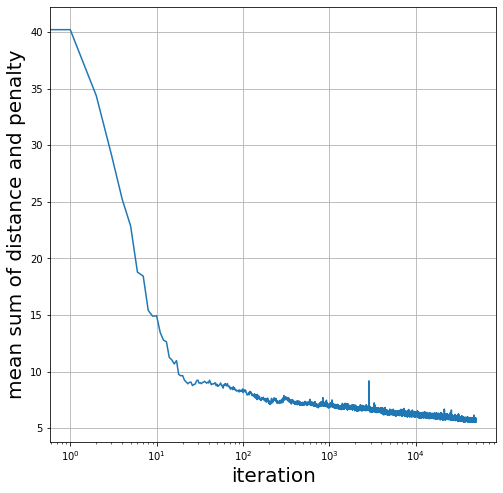

In [21]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
fig.savefig('reward_modified_artificial.png')

In [44]:
f = open('./models/' + file_name + '_best.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel(active_num=1)
model = model.to('cuda')

model.load_state_dict(weights)
_ = model.eval()

In [4]:
with open('cvrp_tw_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [46]:
%%time

model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=0.5, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([11.])
tensor([11.])
tensor([0.])
tensor([17.])
tensor([1.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([1.])
tensor([0.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([6.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([4.])
tensor([10.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([4.])
tensor([3.])
tensor([0.])
tensor([10.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([5.])
tensor([4.])
tensor([0.])
tensor([2.])
tensor([0.])
tensor([2.])
tensor([0.])
tensor([1.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([11.])
tensor([10.])
tensor([10.])
tensor([0.])
tensor([3.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([13.])
tensor([0.])
tensor([9.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([22.])
tensor([0.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([2.])
tensor([0.])
tensor([0.])
te

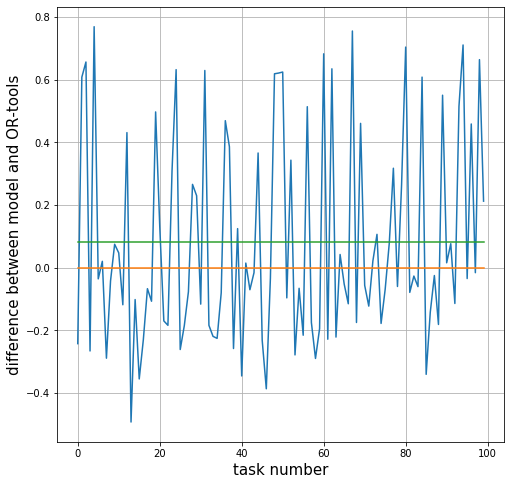

In [47]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
fig.savefig('data_100_05_modified_artificial.png')

In [48]:
%%time

model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([11.])
tensor([11.])
tensor([0.])
tensor([17.])
tensor([1.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([1.])
tensor([0.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([6.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([4.])
tensor([10.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([4.])
tensor([3.])
tensor([0.])
tensor([10.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([5.])
tensor([4.])
tensor([0.])
tensor([2.])
tensor([0.])
tensor([2.])
tensor([0.])
tensor([1.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([11.])
tensor([10.])
tensor([10.])
tensor([0.])
tensor([3.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([13.])
tensor([0.])
tensor([9.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([22.])
tensor([0.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([2.])
tensor([0.])
tensor([0.])
te

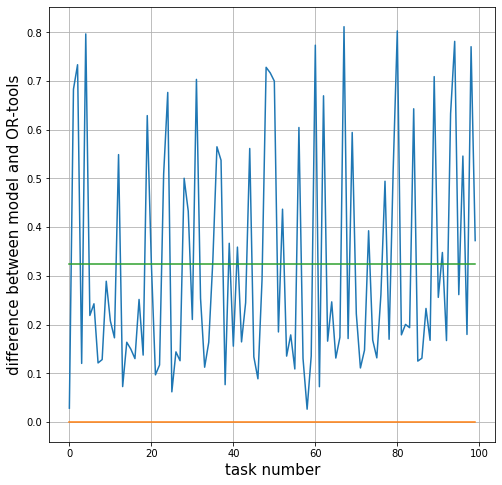

In [49]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
fig.savefig('data_100_10_modified_artificial.png')

## Обучение на реальных графах, но не данных

In [37]:
file_name = 'jampr_mod_real_100_Mar_22_00_33_40_2021'

f = open('./models/' + file_name + '_loss_on_iteration.pkl', 'rb')
loss = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_on_iteration.pkl', 'rb')
reward = pickle.load(f)
f.close()

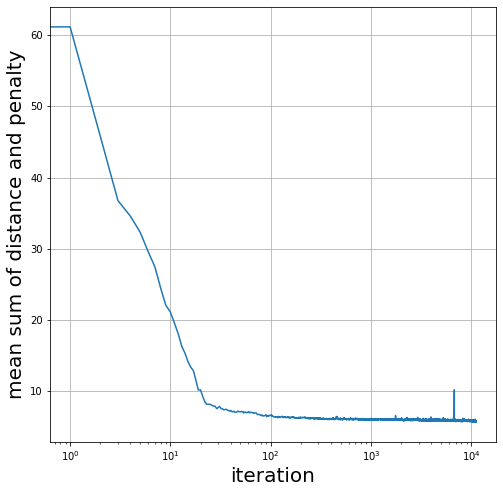

In [51]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
fig.savefig('reward_real_non_data.png')

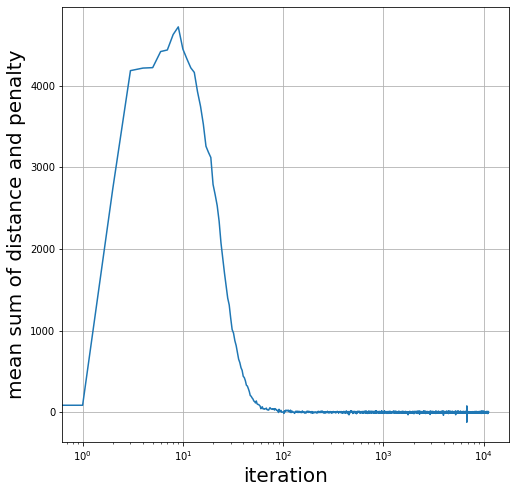

In [52]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [38]:
f = open('./models/' + file_name + '_best_on_iteration.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel(active_num=1)
model = model.to('cuda')

model.load_state_dict(weights)
_ = model.eval()

In [54]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=0.5, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

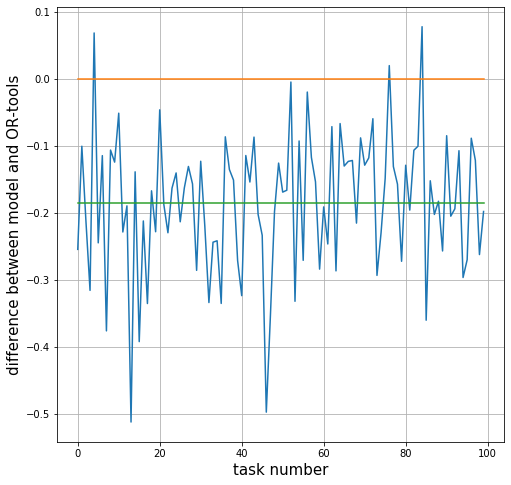

In [55]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
fig.savefig('data_100_05_real_non_data.png')

In [56]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

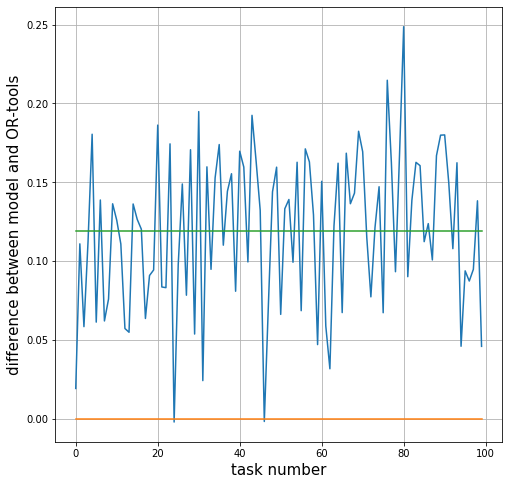

In [57]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
fig.savefig('data_100_10_real_non_data.png')

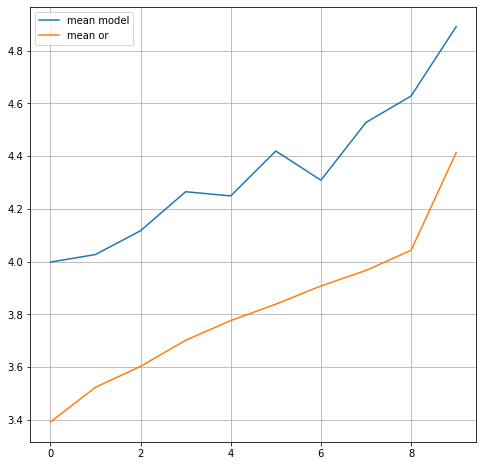

In [58]:
pers = np.percentile(or_metrics, np.arange(10, 101, 10))

bins = (np.array(or_metrics).reshape(-1, 1) <= pers.reshape(1, -1)).argmax(axis=1)

plt.figure(figsize=(8,8))
plt.plot(pd.DataFrame(np.array((model_metrics, or_metrics, bins)).T).groupby(by=2).mean())
plt.grid()
plt.legend(['mean model', 'mean or'])
fig.savefig('group_by_or.png')

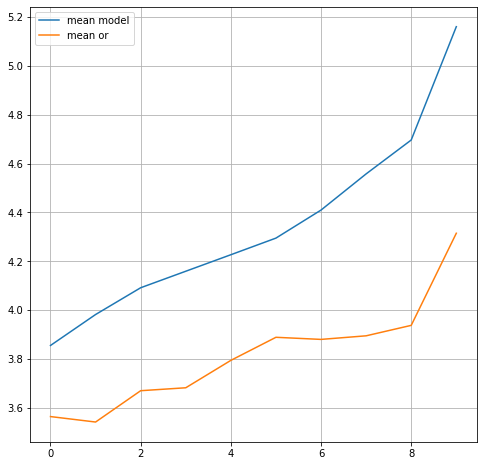

In [59]:
pers = np.percentile(model_metrics, np.arange(10, 101, 10))

bins = (np.array(model_metrics).reshape(-1, 1) <= pers.reshape(1, -1)).argmax(axis=1)

plt.figure(figsize=(8,8))
plt.plot(pd.DataFrame(np.array((model_metrics, or_metrics, bins)).T).groupby(by=2).mean())
plt.grid()
plt.legend(['mean model', 'mean or'])
fig.savefig('group_by_model.png')

In [39]:
mean_gap = []
std_gap = []

time_split = np.geomspace(0.3, 10, num=25, endpoint=True)

i = 0
for time in tqdm(time_split, position=0, leave=False):
    model_metrics = []
    or_metrics = []
    routes = []
    for data in dataset:
        m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=time, sample=False, eps=1e-5, K=12,
                                          return_distances=False)
        model_metrics.append(m1)
        or_metrics.append(m2)
        routes.append(r)
    mean_gap.append((1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()) 
    std_gap.append((1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).std()) 

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

  4%|███▎                                                                               | 1/25 [01:09<27:55, 69.82s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

  8%|██████▋                                                                            | 2/25 [02:24<27:17, 71.20s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 12%|█████████▉                                                                         | 3/25 [03:44<27:06, 73.92s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 16%|█████████████▎                                                                     | 4/25 [05:18<28:01, 80.08s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 20%|████████████████▌                                                                  | 5/25 [06:54<28:15, 84.76s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 24%|███████████████████▉                                                               | 6/25 [08:40<28:52, 91.18s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 28%|███████████████████████▏                                                           | 7/25 [10:36<29:35, 98.66s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 32%|██████████████████████████▏                                                       | 8/25 [12:43<30:21, 107.14s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 36%|█████████████████████████████▌                                                    | 9/25 [15:02<31:04, 116.54s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 40%|████████████████████████████████▍                                                | 10/25 [17:35<31:51, 127.40s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 44%|███████████████████████████████████▋                                             | 11/25 [20:27<32:53, 140.98s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 48%|██████████████████████████████████████▉                                          | 12/25 [23:40<33:52, 156.38s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 52%|██████████████████████████████████████████                                       | 13/25 [27:15<34:47, 173.97s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 56%|█████████████████████████████████████████████▎                                   | 14/25 [31:17<35:40, 194.58s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 60%|████████████████████████████████████████████████▌                                | 15/25 [35:50<36:20, 218.08s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 64%|███████████████████████████████████████████████████▊                             | 16/25 [41:01<36:52, 245.81s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 68%|███████████████████████████████████████████████████████                          | 17/25 [46:57<37:10, 278.83s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 72%|██████████████████████████████████████████████████████████▎                      | 18/25 [53:41<36:55, 316.49s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 76%|████████████████████████████████████████████████████████████                   | 19/25 [1:01:22<35:58, 359.78s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 80%|███████████████████████████████████████████████████████████████▏               | 20/25 [1:10:04<34:02, 408.42s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 84%|██████████████████████████████████████████████████████████████████▎            | 21/25 [1:20:03<31:03, 465.84s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 88%|█████████████████████████████████████████████████████████████████████▌         | 22/25 [1:31:32<26:38, 532.67s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 92%|████████████████████████████████████████████████████████████████████████▋      | 23/25 [1:44:43<20:20, 610.15s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 96%|███████████████████████████████████████████████████████████████████████████▊   | 24/25 [1:59:49<11:38, 698.81s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

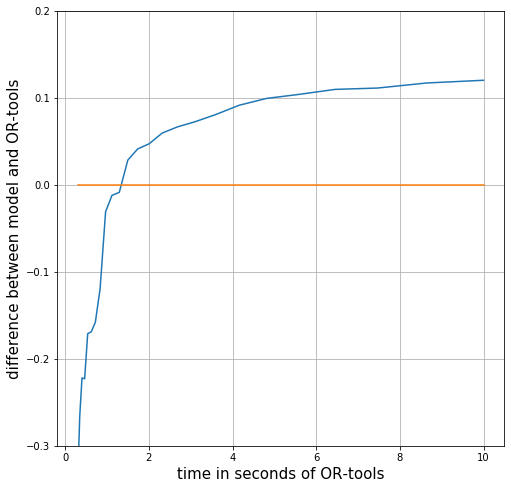

In [41]:
fig = plt.figure(figsize=(8,8))
plt.plot(time_split, mean_gap)
plt.grid()
plt.ylim([-0.3, 0.2])
plt.plot(time_split, [0]*len(time_split))
plt.xlabel('time in seconds of OR-tools', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
fig.savefig('real_non_data_perspective.png')

## Реальные графы, реальные данные

In [65]:
file_name = 'jampr_mod_real_100_Mar_22_01_12_45_2021'

f = open('./models/' + file_name + '_loss_on_iteration.pkl', 'rb')
loss = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_on_iteration.pkl', 'rb')
reward = pickle.load(f)
f.close()

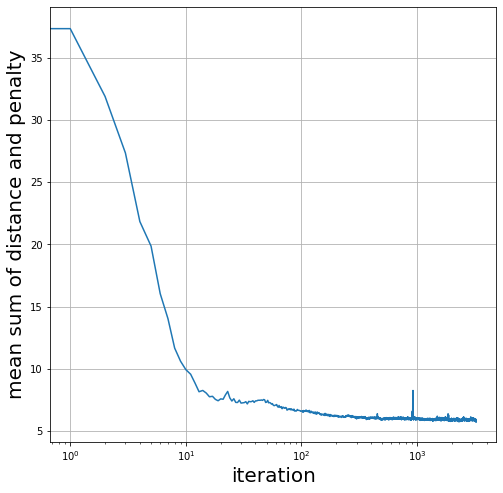

In [66]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
fig.savefig('reward_real_data.png')

In [67]:
f = open('./models/' + file_name + '_best_on_iteration.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel(active_num=1)
model = model.to('cuda')

model.load_state_dict(weights)
_ = model.eval()

In [69]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=0.5, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

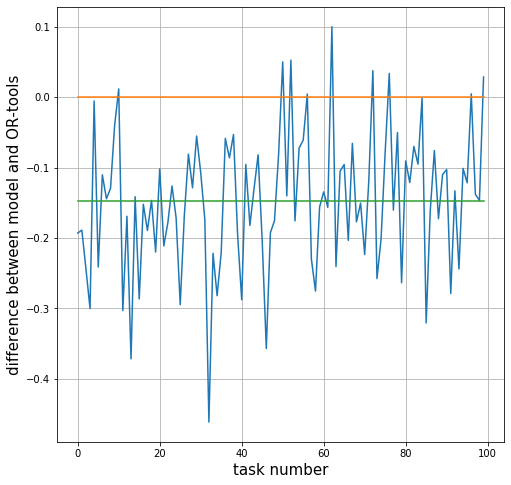

In [70]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
fig.savefig('data_100_05_real_data.png')

In [71]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=False, eps=1e-5, K=12, 
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

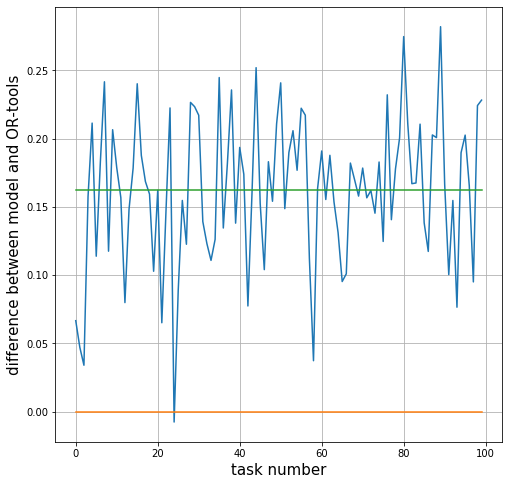

In [72]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
fig.savefig('data_100_10_real_data.png')

## С расстояниями с островками

In [73]:
file_name = 'jampr_mod_real_100_Mar_27_13_56_44_2021'

f = open('./models/' + file_name + '_loss_on_iteration.pkl', 'rb')
loss = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_on_iteration.pkl', 'rb')
reward = pickle.load(f)
f.close()

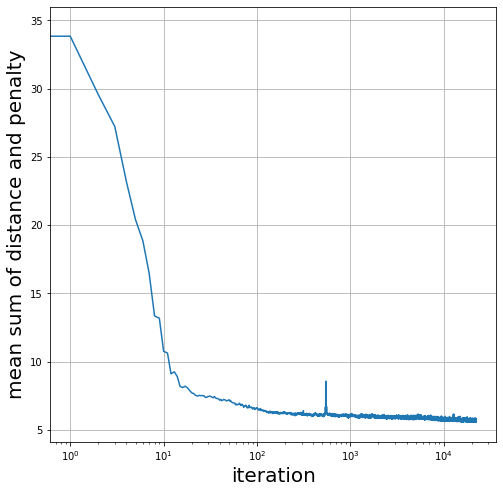

In [74]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
fig.savefig('reward_with_dist_with_outliers.png')

In [75]:
f = open('./models/' + file_name + '_best_on_iteration.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel(active_num=1, distance_dim=20)
model = model.to('cuda')

model.load_state_dict(weights)
_ = model.eval()

In [78]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=0.5, sample=False, eps=1e-5, K=12)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([2.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

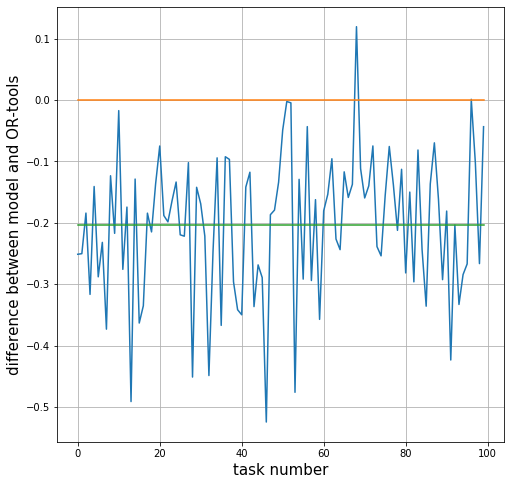

In [79]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
fig.savefig('data_100_05_real_data.png')

In [81]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=False, eps=1e-5, K=12)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([2.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

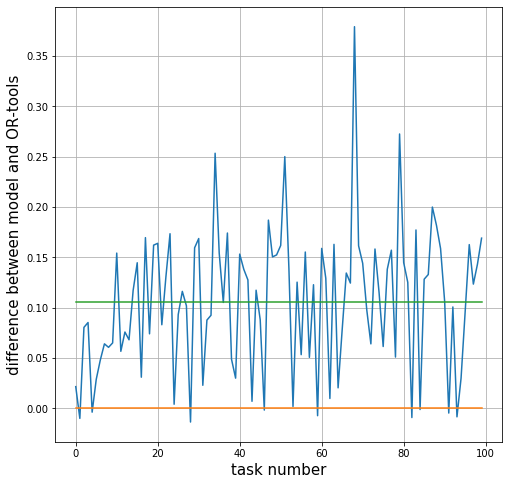

In [82]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
fig.savefig('data_100_10_real_data.png')

## Большие острова

In [46]:
file_name = 'jampr_mod_real_100_Mar_30_21_13_07_2021'

f = open('./models/' + file_name + '_loss_on_iteration.pkl', 'rb')
loss = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_on_iteration.pkl', 'rb')
reward = pickle.load(f)
f.close()

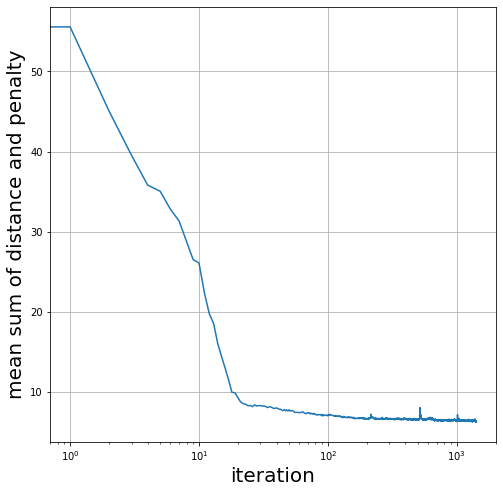

In [84]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
fig.savefig('reward_big_islands.png')

In [47]:
f = open('./models/' + file_name + '_best_on_iteration.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel(active_num=1)
model = model.to('cuda')

model.load_state_dict(weights)
_ = model.eval()

In [86]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=0.5, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

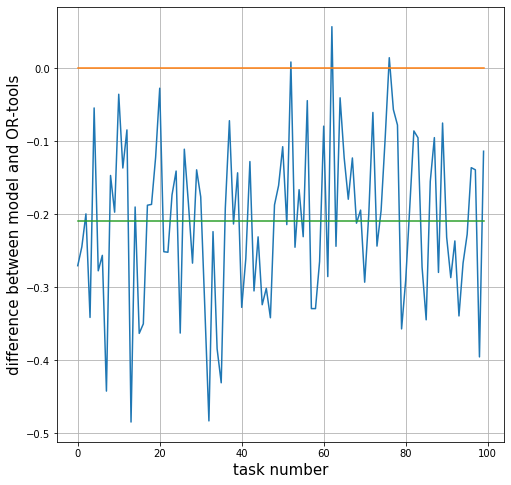

In [87]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
fig.savefig('data_100_05_with_islands.png')

In [88]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

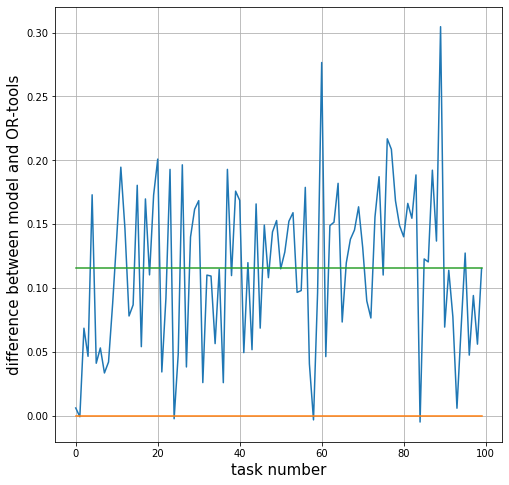

In [89]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
fig.savefig('data_100_10_with_islands.png')

In [48]:
with open('cvrp_tw_dataset_big_islands_train.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [49]:
model_metrics = []
or_metrics = []
routes = []
for data in tqdm(dataset):
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=0.5, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:59<00:32,  1.09it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


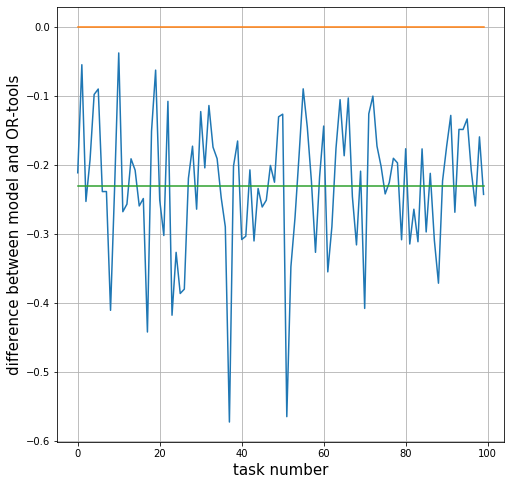

In [50]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
#fig.savefig('data_100_10_with_islands.png')

In [51]:
model_metrics = []
or_metrics = []
routes = []
for data in tqdm(dataset):
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)


 65%|████████████████████████████████████████████████████▋                            | 65/100 [11:17<06:04, 10.41s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [17:21<00:00, 10.42s/it]


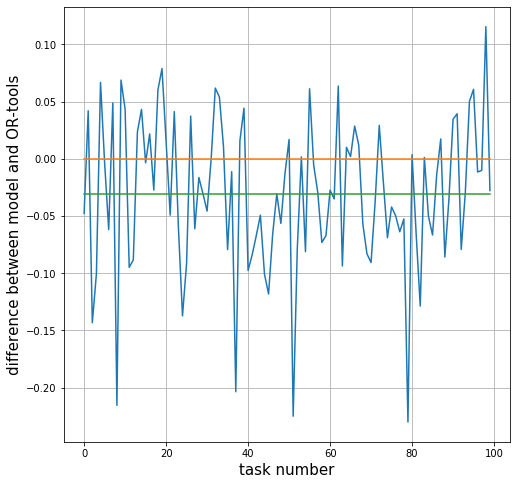

In [52]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
#fig.savefig('data_100_10_with_islands.png')

In [53]:
with open('cvrp_tw_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [55]:
import time

In [56]:
bs_list = [1, 5, 10, 25, 50, 100, 200, 300, 500, 1000, 10000, 20000, 50000, 100000]
print('f')
all_model_metrics = []
all_model_time = []
device="cuda"
n=100
sample=True
K=12
return_distances=False
for bs in tqdm(bs_list):
    model_metrics = []
    t1 = time.time()
    for data in dataset:
        if bs > 100:
            m_list = []
            for i in range(bs//100):
                env = LogEnv(n=n, batch_size=100, active_num=1, K=K, return_distances=return_distances)
                features, distances, mask = env.reset(data=data)
                features[0] = features[0].to(device)
                features[1] = features[1].to(device)
                flag_done = False
                t = 0
                precomputed = None
                while not flag_done:
                    v, _, precomputed = model(features, mask, t, precomputed, sample)
                    v = v.to('cpu')
                    features, mask, flag_done = env.step(v)
                    features[1] = features[1].to(device)
                    t += 1
                routes_length = env.vehicle[:, :, -1].sum(dim=1).to('cpu')
                routes_length += check_missing_vertexes_jampr(env.tour_plan, n)
                m = routes_length.min().detach().item()
                m_list.append(m)
            model_metrics.append(min(m_list))
        else:
            env = LogEnv(n=n, batch_size=bs, active_num=1, K=K, return_distances=return_distances)
            features, distances, mask = env.reset(data=data)
            features[0] = features[0].to(device)
            features[1] = features[1].to(device)
            flag_done = False
            t = 0
            precomputed = None
            while not flag_done:
                v, _, precomputed = model(features, mask, t, precomputed, sample)
                v = v.to('cpu')
                features, mask, flag_done = env.step(v)
                features[1] = features[1].to(device)
                t += 1
            routes_length = env.vehicle[:, :, -1].sum(dim=1).to('cpu')
            routes_length += check_missing_vertexes_jampr(env.tour_plan, n)
            m = routes_length.min().detach().item()
            model_metrics.append(m)
    t2 = time.time()
    all_model_metrics.append(model_metrics)
    all_model_time.append((t2 - t1)/100)


  0%|                                                                                           | 0/14 [00:00<?, ?it/s]

f



 93%|████████████████████████████████████████████████████████████████████▋     | 13/14 [22:58:18<5:48:46, 20926.90s/it]

KeyboardInterrupt: 

In [60]:
np.array(all_model_metrics).mean(axis=1)

array([4.65535136, 4.44894943, 4.38265713, 4.29488206, 4.27342269,
       4.2381023 , 4.21914357, 4.2085823 , 4.17157537, 4.15893074,
       4.09119849, 4.07998315, 4.05872496])

In [90]:
all_model_time

[0.42837932109832766,
 0.4801073265075684,
 0.5078458428382874,
 0.609129068851471,
 0.7966996049880981,
 0.9893499708175659,
 2.0065982031822203,
 2.9731454396247865,
 4.989526040554047,
 10.004908058643341,
 100.30814465761185,
 200.14749117136,
 502.7479956102371]

In [93]:
with open('sampling_metrics.pkl', 'wb') as f:
    pickle.dump((all_model_metrics, all_model_time), f)

In [64]:
or_metrics

[7.102557555555555,
 6.225249652777778,
 7.146321416666668,
 6.379337625,
 6.68904375,
 7.560532055555556,
 6.922652444444444,
 5.939015930555556,
 7.329240333333335,
 6.345506597222222,
 6.5379719722222225,
 7.327106125,
 7.19257138888889,
 6.033930236111112,
 6.460485736111112,
 6.004379277777778,
 6.025735888888889,
 6.531450930555557,
 6.156907111111112,
 6.532300513888889,
 6.566770527777779,
 5.684620069444445,
 6.263138625000001,
 6.760622361111111,
 7.197930291666667,
 6.262497319444445,
 5.651039069444445,
 6.465846847222223,
 6.2759441944444445,
 6.837481069444445,
 6.865708,
 6.761777402777778,
 6.244636236111112,
 7.041349152777779,
 6.389712569444445,
 6.577937222222222,
 6.051349236111111,
 7.616453333333334,
 5.795351472222223,
 5.926240347222223,
 6.106728847222223,
 7.5415135,
 6.894362972222223,
 6.968937138888889,
 6.977221861111112,
 7.082180236111112,
 6.895307444444445,
 6.854351444444445,
 6.989944027777779,
 6.7041085277777785,
 6.589987958333333,
 7.39586065277

In [68]:
or_metrics = []
routes = []
for data in dataset:
    _, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=True, eps=1e-5, K=12,
                                      return_distances=False, bs=1)
    or_metrics.append(m2)
    routes.append(r)

In [79]:
1 - 3.8203083729166663/4.158

0.08121491752845933

In [69]:
np.mean(or_metrics)

3.8203083729166663

In [67]:
np.mean(or_metrics)

5.2183371986111124

In [81]:
mo_metrics = []
or_metrics = []
routes = []
for data in tqdm(dataset):
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=0.5, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    duplicates.append(100 - data['coords'].shape[0])
    mo_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

  1%|▊                                                                                 | 1/100 [00:00<01:32,  1.08it/s]

  2%|█▋                                                                                | 2/100 [00:01<01:30,  1.08it/s]

  3%|██▍                                                                               | 3/100 [00:02<01:29,  1.09it/s]

  4%|███▎                                                                              | 4/100 [00:03<01:29,  1.07it/s]

  5%|████                                                                              | 5/100 [00:04<01:27,  1.08it/s]

  6%|████▉                                                                             | 6/100 [00:05<01:25,  1.09it/s]

  7%|█████▋                                                                            | 7/100 [00:06<01:24,  1.10it/s]

  8%|██████▌                  

 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:58<00:32,  1.12it/s]

 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:59<00:31,  1.10it/s]

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [01:00<00:30,  1.10it/s]

 67%|██████████████████████████████████████████████████████▎                          | 67/100 [01:00<00:30,  1.10it/s]

 68%|███████████████████████████████████████████████████████                          | 68/100 [01:01<00:29,  1.08it/s]

 69%|███████████████████████████████████████████████████████▉                         | 69/100 [01:02<00:28,  1.09it/s]

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [01:03<00:27,  1.09it/s]

 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [01:04<00:26,  1.10it/s]

 72%|███████████████████████████

In [83]:
duplicates = []
for data in dataset:
    duplicates.append(100 - np.unique(data['coords'], axis=0).shape[0])

In [85]:
max(duplicates)

15

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

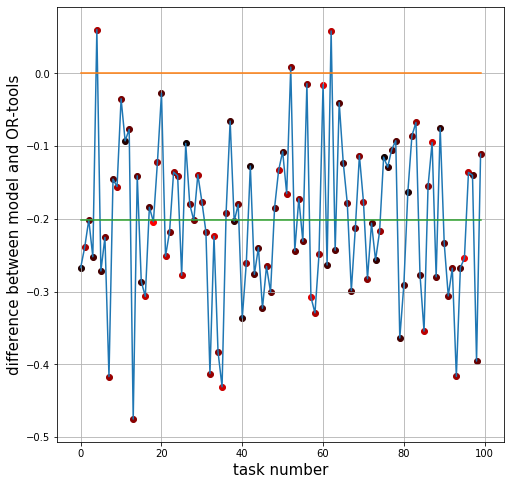

In [89]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(mo_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(mo_metrics)).mean()]*100)
for i in range(len(dataset)):
    plt.scatter(i,(1 - torch.tensor(or_metrics)/torch.tensor(mo_metrics))[i], c=[duplicates[i]/15, 0, 0])
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()

In [21]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=0.5, sample=True, eps=1e-5, K=12,
                                      return_distances=False, bs=100)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

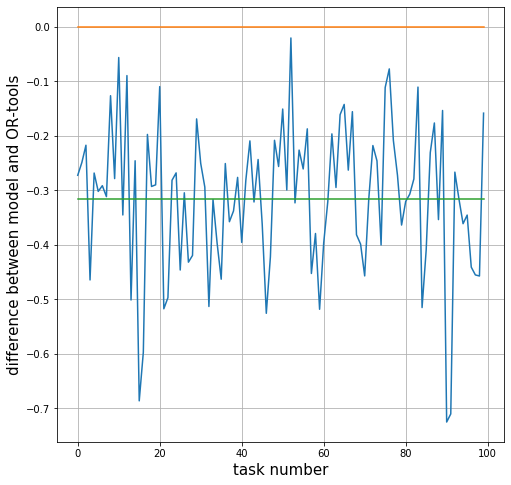

In [22]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()

In [23]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=True, eps=1e-5, K=12,
                                      return_distances=False, bs=100)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.

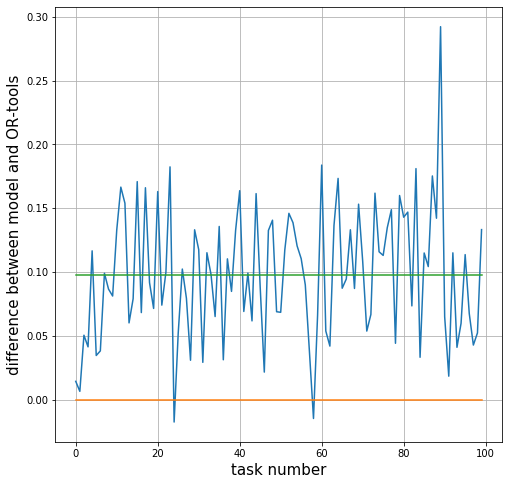

In [24]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()

In [78]:
for data in dataset:
    print(100 - np.unique(data['coords'], axis=0).shape[0])

2
10
6
4
10
4
7
9
5
10
7
2
6
8
6
4
11
5
15
9
5
11
7
9
9
11
1
7
7
10
8
8
9
12
8
12
8
4
3
7
3
9
2
5
5
5
8
6
6
11
4
10
8
6
8
6
8
13
10
9
13
4
11
5
5
5
7
5
7
8
10
8
5
3
9
1
3
5
5
4
5
2
7
9
5
11
8
12
6
3
6
7
7
9
5
14
11
5
6
7


In [76]:
np.unique(data['coords'], axis=0).shape

(93, 2)

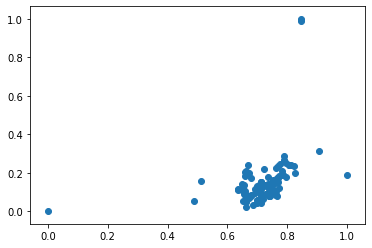

In [12]:
plt.scatter(dataset[-1]['coords'][:, 0], dataset[-1]['coords'][:, 1])

(array([83.,  0.,  0., 16.,  0.,  0.,  1.,  0.,  1.,  1.]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 10 Patch objects>)

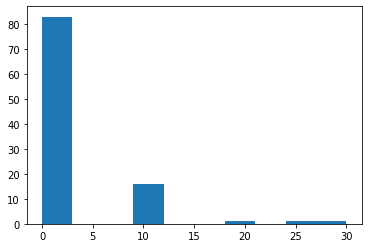

In [27]:
plt.hist(dataset[-1]['demands'], bins=10)

(array([19., 17., 17., 16., 14., 19.]),
 array([  0., 100., 200., 300., 400., 500., 600.]),
 <a list of 6 Patch objects>)

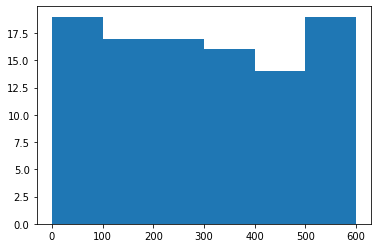

In [19]:
plt.hist(dataset[-1]['time_windows'][:, 0], bins=6)

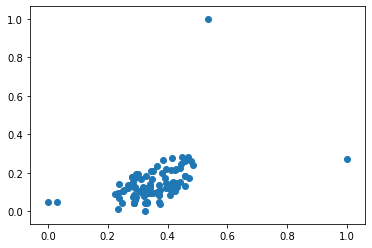

In [9]:
plt.scatter(dataset[90]['coords'][:, 0], dataset[90]['coords'][:, 1])

(array([78., 19.,  3.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.]),
 <a list of 10 Patch objects>)

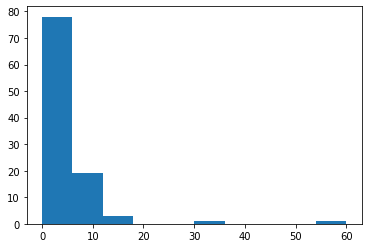

In [28]:
plt.hist(dataset[90]['demands'], bins=10)

(array([21., 10., 22., 14., 19., 16.]),
 array([  0., 100., 200., 300., 400., 500., 600.]),
 <a list of 6 Patch objects>)

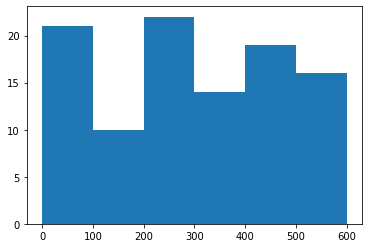

In [20]:
plt.hist(dataset[90]['time_windows'][:, 0], bins=6)

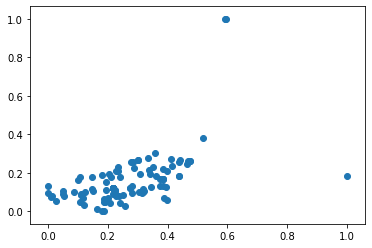

In [10]:
plt.scatter(dataset[24]['coords'][:, 0], dataset[24]['coords'][:, 1])

(array([86., 12.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  2.]),
 array([ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.]),
 <a list of 10 Patch objects>)

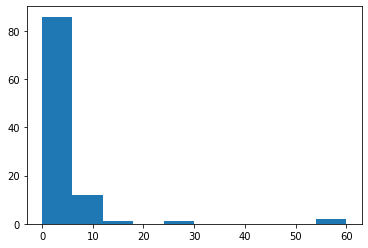

In [29]:
plt.hist(dataset[24]['demands'], bins=10)

(array([14., 18., 21., 12., 25., 12.]),
 array([  0., 100., 200., 300., 400., 500., 600.]),
 <a list of 6 Patch objects>)

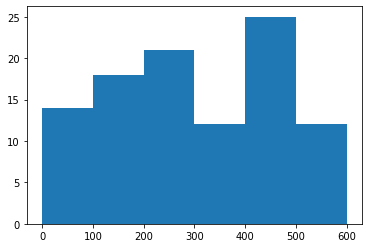

In [21]:
plt.hist(dataset[24]['time_windows'][:, 0], bins=6)

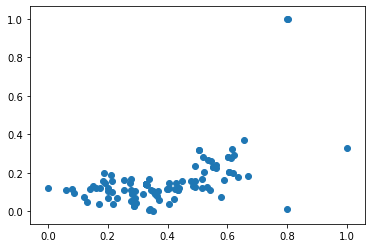

In [11]:
plt.scatter(dataset[58]['coords'][:, 0], dataset[58]['coords'][:, 1])

(array([85.,  0., 14.,  1.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <a list of 10 Patch objects>)

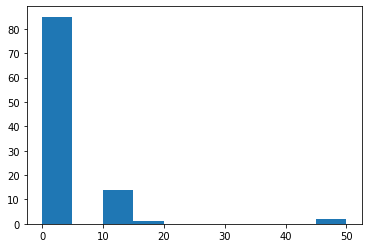

In [30]:
plt.hist(dataset[58]['demands'], bins=10)

(array([14., 11., 15., 14., 26., 22.]),
 array([  0., 100., 200., 300., 400., 500., 600.]),
 <a list of 6 Patch objects>)

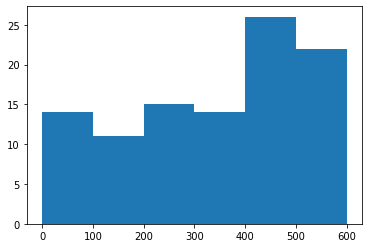

In [22]:
plt.hist(dataset[58]['time_windows'][:, 0], bins=6)

## Проверка модели для проблем 500

In [124]:
file_name = 'jampr_mod_real_500_Mar_31_22_40_43_2021'

f = open('./models/' + file_name + '_loss_on_iteration.pkl', 'rb')
loss = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_on_iteration.pkl', 'rb')
reward = pickle.load(f)
f.close()

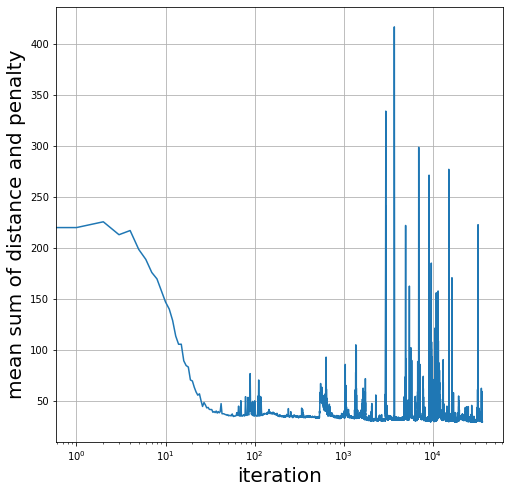

In [91]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
fig.savefig('reward_modified_artificial.png')

In [125]:
f = open('./models/' + file_name + '_best_on_iteration.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel(active_num=1)
model = model.to('cuda')

model.load_state_dict(weights)
_ = model.eval()

In [93]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=0.5, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([21.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.]

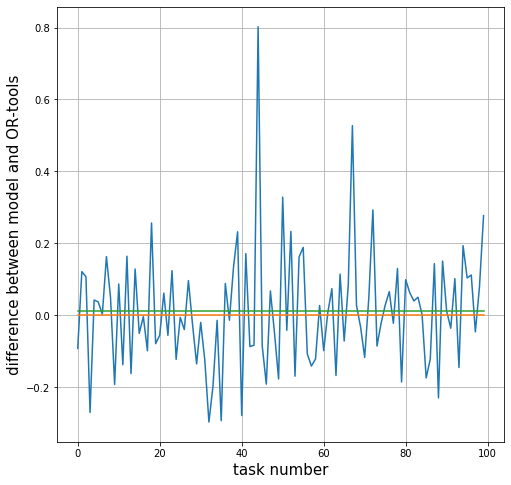

In [94]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
fig.savefig('data_500_05_real_data.png')

In [95]:
with open('cvrp_tw_500_dataset.pkl', 'rb') as f:
    dataset_500 = pickle.load(f)

In [126]:
model_metrics_500 = []
or_metrics_500 = []
routes_500 = []
for data in dataset_500:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=500, time_limit=10, sample=False, eps=1e-5, K=50,
                                      return_distances=False)
    model_metrics_500.append(m1)
    or_metrics_500.append(m2)
    routes_500.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

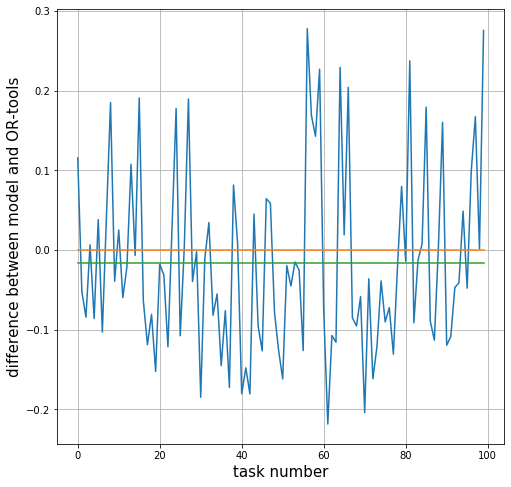

In [127]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics_500)/torch.tensor(model_metrics_500))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics_500)/torch.tensor(model_metrics_500)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
fig.savefig('data_500_10_real_data.png')

In [128]:
model_metrics_500 = []
or_metrics_500 = []
routes_500 = []
for data in dataset_500:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=500, time_limit=60, sample=False, eps=1e-5, K=50,
                                      return_distances=False)
    model_metrics_500.append(m1)
    or_metrics_500.append(m2)
    routes_500.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

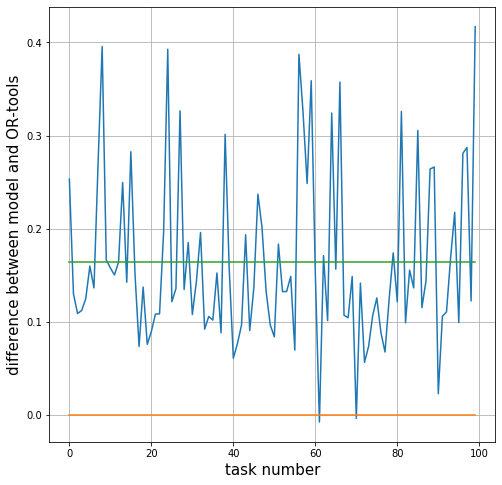

In [129]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics_500)/torch.tensor(model_metrics_500))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics_500)/torch.tensor(model_metrics_500)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
fig.savefig('data_500_60_real_data.png')

In [100]:
mean_gap = []
std_gap = []

time_split = [2, 3, 4, 5, 7, 10, 30, 60, 90, 120]

In [101]:
i = 0
for time in tqdm(time_split, position=0, leave=False):
    model_metrics = []
    or_metrics = []
    routes = []
    for data in dataset_500:
        m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=500, time_limit=time, sample=False, eps=1e-5, K=50,
                                          return_distances=False)
        model_metrics.append(m1)
        or_metrics.append(m2)
        routes.append(r)
    mean_gap.append((1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()) 
    std_gap.append((1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).std()) 

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 10%|████████                                                                        | 1/10 [07:36<1:08:26, 456.31s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 20%|████████████████                                                                | 2/10 [16:51<1:04:46, 485.86s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 30%|████████████████████████                                                        | 3/10 [27:45<1:02:35, 536.54s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 40%|████████████████████████████████                                                | 4/10 [40:22<1:00:14, 602.43s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 50%|█████████████████████████████████████████                                         | 5/10 [56:16<59:00, 708.14s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 60%|████████████████████████████████████████████████                                | 6/10 [1:17:11<58:08, 872.12s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 70%|█████████████████████████████████████████████████████▉                       | 7/10 [2:11:33<1:19:27, 1589.03s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 80%|█████████████████████████████████████████████████████████████▌               | 8/10 [3:55:54<1:39:41, 2990.74s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 90%|█████████████████████████████████████████████████████████████████████▎       | 9/10 [6:30:12<1:21:10, 4870.77s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

In [102]:
mean_gap.append((1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()) 
std_gap.append((1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).std()) 

In [105]:
mean_gap

[tensor(-23.4318),
 tensor(-23.4318),
 tensor(-0.2788),
 tensor(-0.2122),
 tensor(-0.1224),
 tensor(-0.0337),
 tensor(0.0990),
 tensor(0.1637),
 tensor(0.1841),
 tensor(0.1910),
 tensor(0.1910)]

In [106]:
time_split

[2, 3, 4, 5, 7, 10, 30, 60, 90, 120]

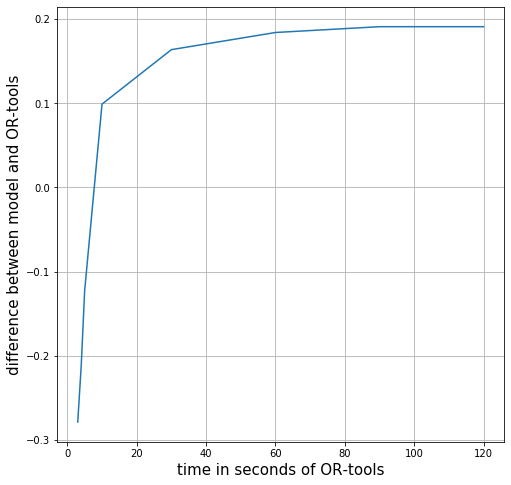

In [108]:
fig = plt.figure(figsize=(8,8))
plt.plot(time_split[1:], mean_gap[2:])
plt.grid()
plt.xlabel('time in seconds of OR-tools', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
fig.savefig('real_non_data_perspective_500.png')

## Больше параметров

In [27]:
file_name = 'jampr_mod_real_100_Apr__5_21_28_30_2021'

f = open('./models/' + file_name + '_loss_on_iteration.pkl', 'rb')
loss = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_on_iteration.pkl', 'rb')
reward = pickle.load(f)
f.close()

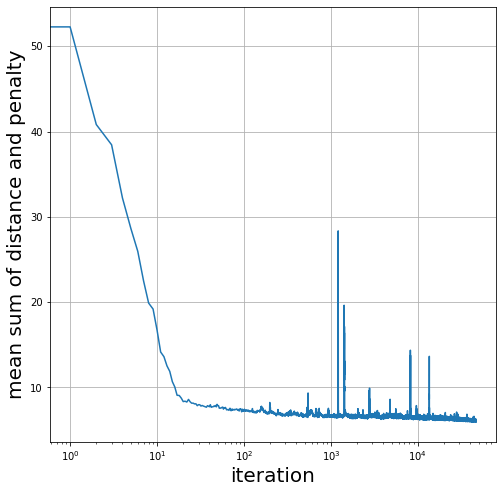

In [110]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()

fig.savefig('reward_more_params.png')

In [28]:
f = open('./models/' + file_name + '_best_on_iteration.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel(active_num=1, dec_dm=256, en_dm=256)
model = model.to('cuda')

model.load_state_dict(weights)
_ = model.eval()

In [29]:
with open('cvrp_tw_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [113]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=0.5, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

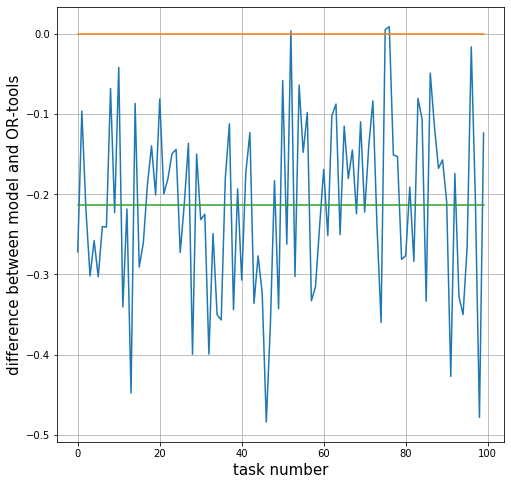

In [114]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
fig.savefig('data_100_05_more_params.png')

In [115]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

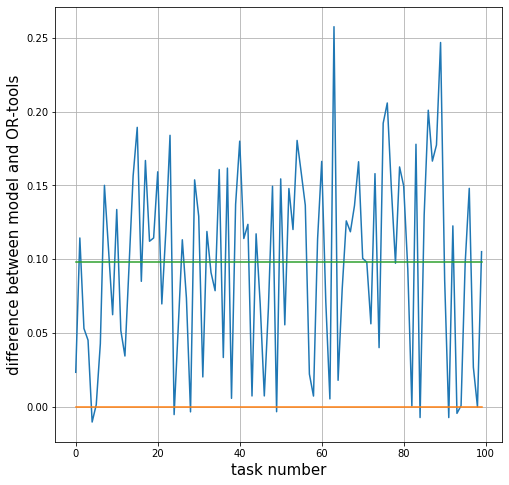

In [116]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
fig.savefig('data_100_10_more_params.png')

In [30]:
mean_gap = []
std_gap = []

time_split = np.geomspace(0.3, 10, num=25, endpoint=True)

In [31]:
for time in tqdm(time_split, position=0, leave=False):
    model_metrics = []
    or_metrics = []
    routes = []
    for data in dataset:
        m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=time, sample=False, eps=1e-5, K=12,
                                          return_distances=False)
        model_metrics.append(m1)
        or_metrics.append(m2)
        routes.append(r)
    mean_gap.append((1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()) 
    std_gap.append((1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).std()) 

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

  4%|███▎                                                                               | 1/25 [01:10<28:09, 70.38s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

  8%|██████▋                                                                            | 2/25 [02:23<27:15, 71.12s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 12%|█████████▉                                                                         | 3/25 [03:41<26:50, 73.18s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 16%|█████████████▎                                                                     | 4/25 [05:06<26:51, 76.75s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 20%|████████████████▌                                                                  | 5/25 [06:38<27:07, 81.38s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 24%|███████████████████▉                                                               | 6/25 [08:18<27:33, 87.03s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 28%|███████████████████████▏                                                           | 7/25 [10:08<28:11, 94.00s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 32%|██████████████████████████▏                                                       | 8/25 [12:10<28:58, 102.27s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 36%|█████████████████████████████▌                                                    | 9/25 [14:24<29:50, 111.93s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 40%|████████████████████████████████▍                                                | 10/25 [16:54<30:48, 123.24s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 44%|███████████████████████████████████▋                                             | 11/25 [19:41<31:50, 136.44s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 48%|██████████████████████████████████████▉                                          | 12/25 [22:49<32:52, 151.74s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 52%|██████████████████████████████████████████                                       | 13/25 [26:20<33:54, 169.57s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 56%|█████████████████████████████████████████████▎                                   | 14/25 [30:18<34:52, 190.25s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 60%|████████████████████████████████████████████████▌                                | 15/25 [34:49<35:42, 214.24s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 64%|███████████████████████████████████████████████████▊                             | 16/25 [39:55<36:16, 241.88s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 68%|███████████████████████████████████████████████████████                          | 17/25 [45:44<36:31, 273.98s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 72%|██████████████████████████████████████████████████████████▎                      | 18/25 [52:22<36:19, 311.32s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 76%|█████████████████████████████████████████████████████████████▌                   | 19/25 [59:58<35:28, 354.75s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 80%|███████████████████████████████████████████████████████████████▏               | 20/25 [1:08:39<33:43, 404.62s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 84%|██████████████████████████████████████████████████████████████████▎            | 21/25 [1:18:37<30:49, 462.39s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 88%|█████████████████████████████████████████████████████████████████████▌         | 22/25 [1:30:01<26:27, 529.07s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 92%|████████████████████████████████████████████████████████████████████████▋      | 23/25 [1:43:07<20:12, 606.04s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 96%|███████████████████████████████████████████████████████████████████████████▊   | 24/25 [1:58:14<11:36, 696.33s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

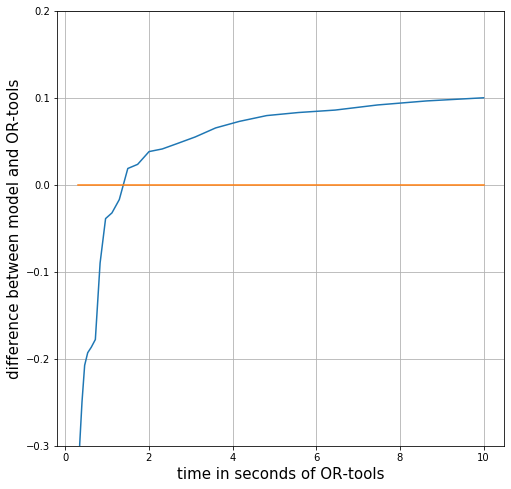

In [34]:
fig = plt.figure(figsize=(8, 8))
plt.plot(time_split, mean_gap)
plt.grid()
plt.plot(time_split, [0]*len(time_split))
plt.xlabel('time in seconds of OR-tools', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.ylim([-0.3, 0.2])
fig.savefig('real_non_data_perspective_more_params.png')

## Фиксированное депо

In [22]:
file_name = 'jampr_mod_real_100_Apr_12_21_42_10_2021'

f = open('./models/' + file_name + '_loss_on_iteration.pkl', 'rb')
loss = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_on_iteration.pkl', 'rb')
reward = pickle.load(f)
f.close()

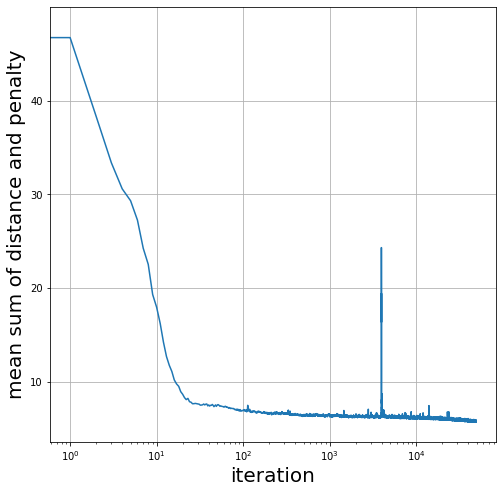

In [23]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()

#fig.savefig('reward_more_params.png')

In [24]:
f = open('./models/' + file_name + '_best_on_iteration.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel(active_num=1)
model = model.to('cuda')

model.load_state_dict(weights)
_ = model.eval()

In [15]:
with open('cvrp_tw_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [17]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=0.5, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([2.])
tensor([1.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([3.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([1.])
tensor([2.])
tensor([0.])
tensor([4.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([7.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([4.])
tensor([1.])
tensor([3.])
tensor([0.])

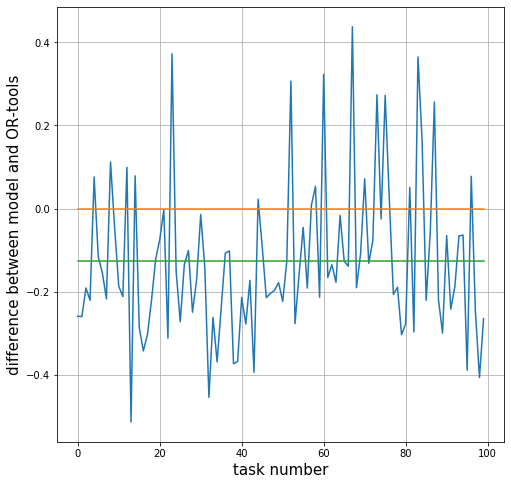

In [18]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
#fig.savefig('data_100_10_more_params.png')

In [25]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([2.])
tensor([1.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([3.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([1.])
tensor([2.])
tensor([0.])
tensor([4.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([7.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([4.])
tensor([1.])
tensor([3.])
tensor([0.])

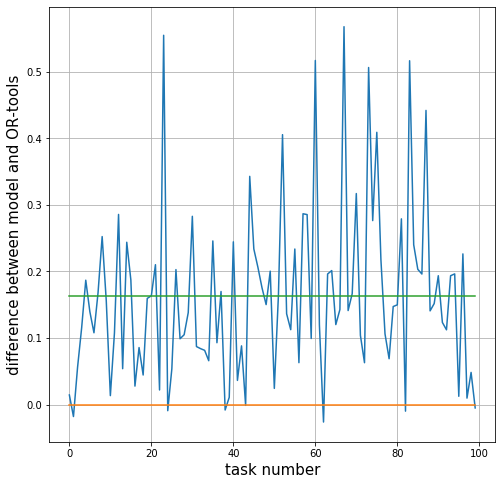

In [26]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()
#fig.savefig('data_100_10_more_params.png')

## 20k Модель

In [14]:
file_name = 'jampr_mod_real_100_Apr_16_22_56_45_2021'

f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_val.pkl', 'rb')
reward_val = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_test.pkl', 'rb')
reward_test = pickle.load(f)
f.close()

(5, 50)

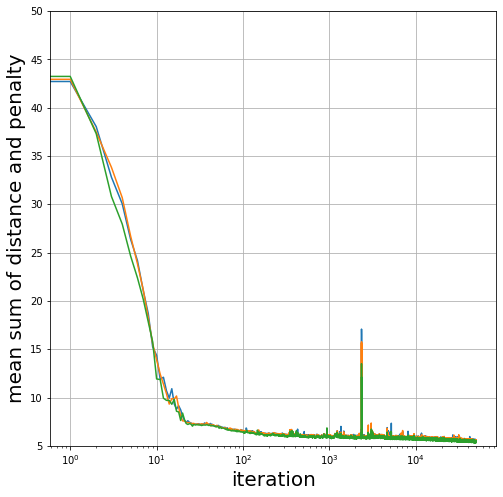

In [15]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.plot(reward_val)
plt.plot(reward_test)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
plt.ylim([5, 50])

(5, 50)

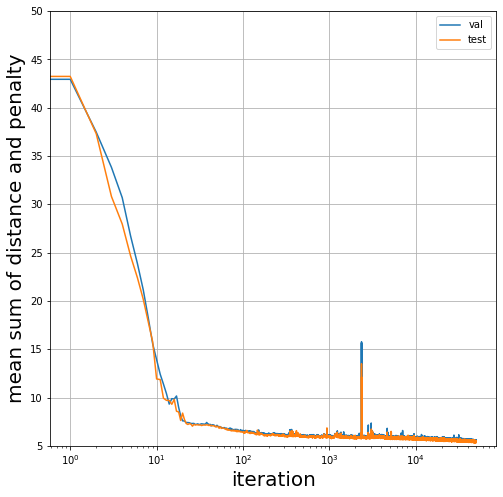

In [17]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward_val)
plt.plot(reward_test)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.legend(['val', 'test'])
plt.grid()
plt.ylim([5, 50])

(5, 50)

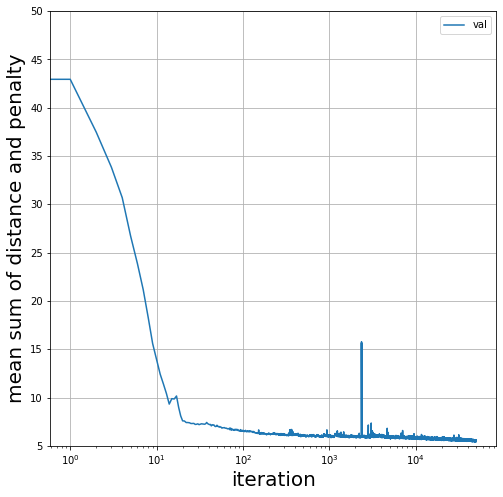

In [18]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward_val)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.legend(['val'])
plt.grid()
plt.ylim([5, 50])

(5, 50)

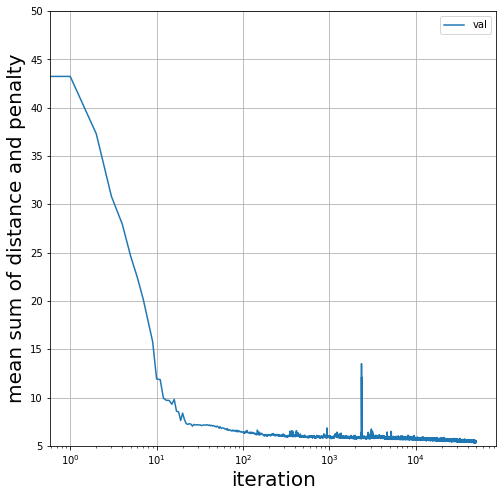

In [19]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward_test)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.legend(['val'])
plt.grid()
plt.ylim([5, 50])

In [16]:
f = open('./models/' + file_name + '_best_on_iteration.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel(active_num=1)
model = model.to('cuda')

model.load_state_dict(weights)
_ = model.eval()

In [3]:
with open('cvrp_tw_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [18]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=0.5, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

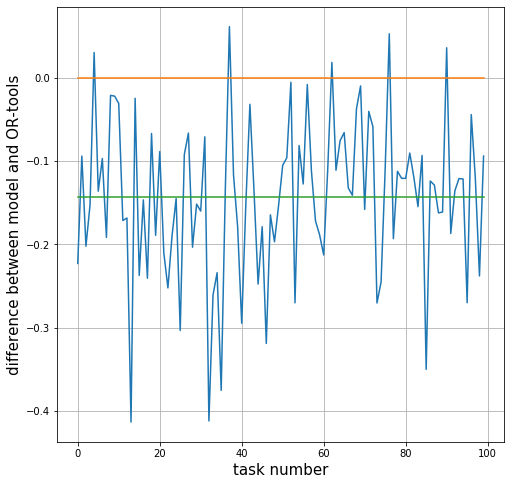

In [19]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()

In [20]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

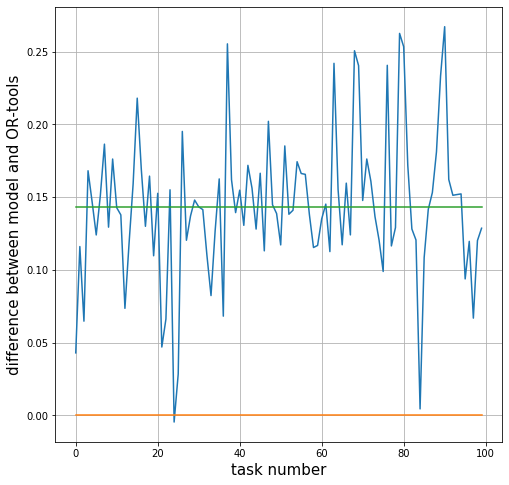

In [21]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()

In [22]:
f = open('./models/' + file_name + '.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel(active_num=1)
model = model.to('cuda')

model.load_state_dict(weights)
_ = model.eval()

In [23]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=0.5, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

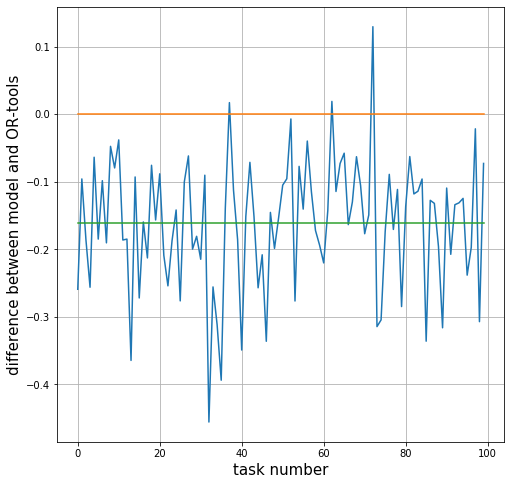

In [24]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()

In [25]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

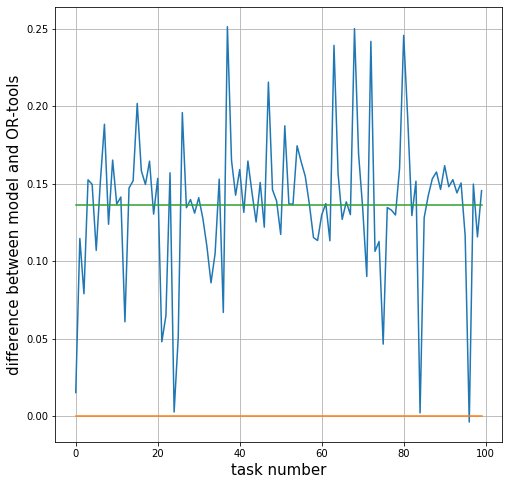

In [26]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()

## 10k Модель

In [4]:
file_name = 'jampr_mod_real_100_Apr_17_00_25_03_2021'

f = open('./models/' + file_name + '_loss_on_iteration.pkl', 'rb')
loss = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_on_iteration.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [5]:
f = open('./models/' + file_name + '_loss_on_iteration.pkl', 'rb')
loss = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_on_iteration.pkl', 'rb')
reward = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_val_on_iteration.pkl', 'rb')
reward_val = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_test_on_iteration.pkl', 'rb')
reward_test = pickle.load(f)
f.close()

(5, 50)

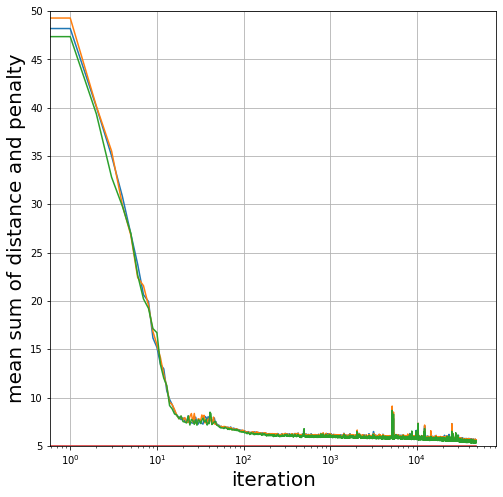

In [6]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.plot(reward_val)
plt.plot(reward_test)
plt.plot([5]*len(reward))
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
plt.ylim([5, 50])

In [8]:
f = open('./models/' + file_name + '.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel(active_num=1)
model = model.to('cuda')

model.load_state_dict(weights)
_ = model.eval()

In [35]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=0.5, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

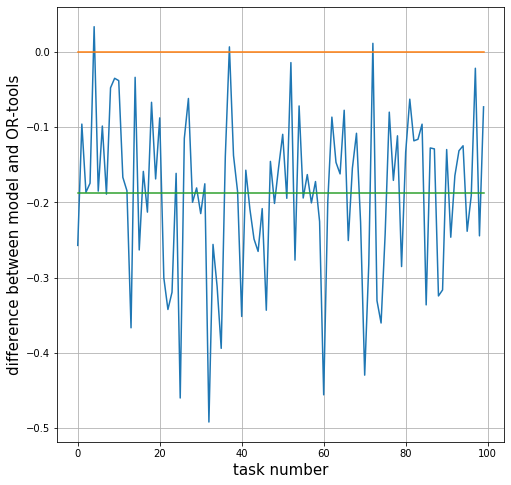

In [36]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()

In [39]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

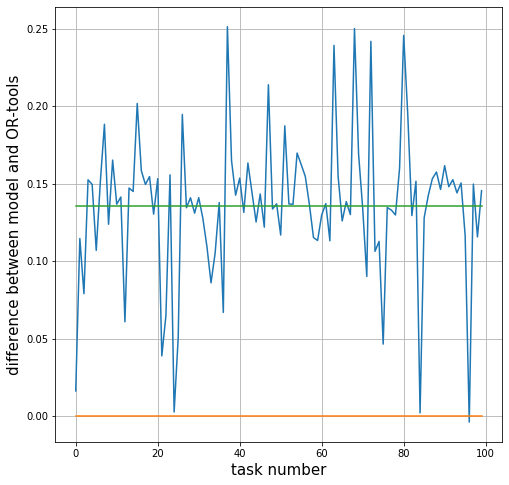

In [40]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()

## Москва

In [31]:
file_name = 'jampr_mod_real_100_Apr_19_19_25_06_2021'

f = open('./models/' + file_name + '_loss_on_iteration.pkl', 'rb')
loss = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_on_iteration.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [32]:
f = open('./models/' + file_name + '_loss_on_iteration.pkl', 'rb')
loss = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_on_iteration.pkl', 'rb')
reward = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_val_on_iteration.pkl', 'rb')
reward_val = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_test_on_iteration.pkl', 'rb')
reward_test = pickle.load(f)
f.close()

(5, 50)

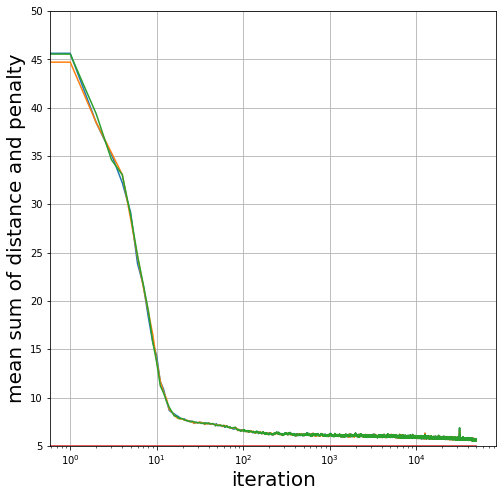

In [33]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.plot(reward_val)
plt.plot(reward_test)
plt.plot([5]*len(reward))
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
plt.ylim([5, 50])

In [34]:
f = open('./models/' + file_name + '.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel(active_num=1)
model = model.to('cuda')

model.load_state_dict(weights)
_ = model.eval()

In [35]:
with open('cvrp_tw_dataset_moscow_test.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [36]:
model_metrics = []
or_metrics = []
routes = []
for data in tqdm(dataset):
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=0.5, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

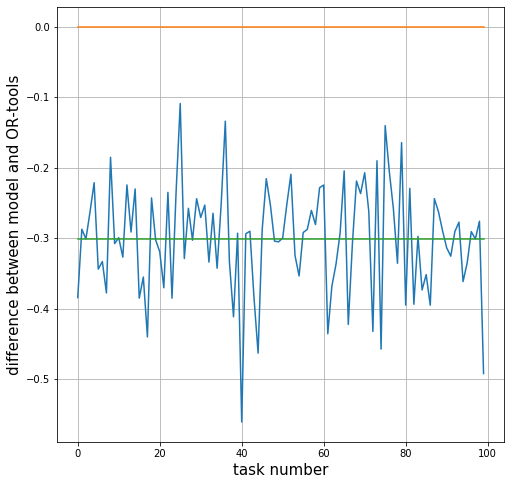

In [37]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()

In [38]:
model_metrics = []
or_metrics = []
routes = []
for data in tqdm(dataset):
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [17:21<00:00, 10.41s/it]


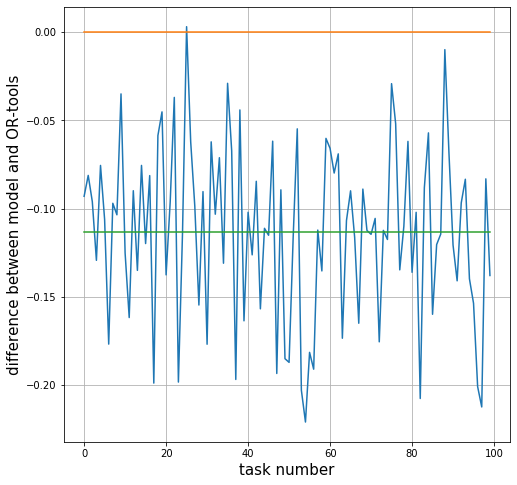

In [39]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()

In [40]:
with open('cvrp_tw_dataset_moscow_train.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [42]:
model_metrics = []
or_metrics = []
routes = []
for data in tqdm(dataset):
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=0.5, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:59<00:31,  1.09it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


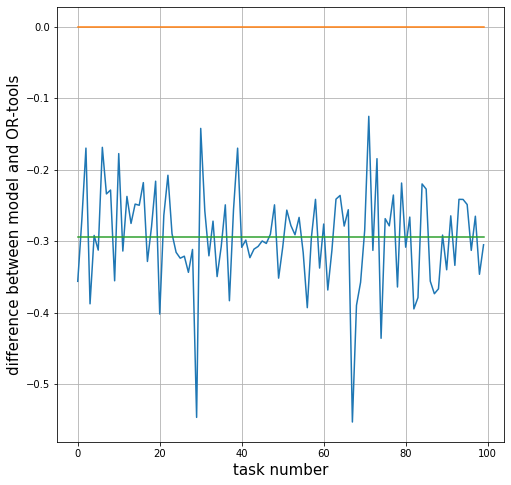

In [43]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()

In [44]:
model_metrics = []
or_metrics = []
routes = []
for data in tqdm(dataset):
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)


 65%|████████████████████████████████████████████████████▋                            | 65/100 [11:17<06:05, 10.44s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [17:22<00:00, 10.43s/it]


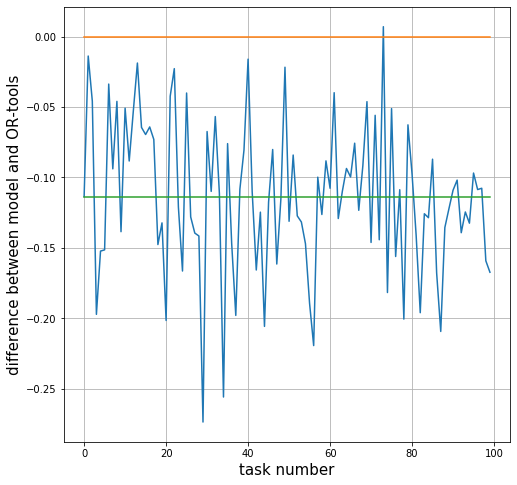

In [45]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.xlabel('task number', fontsize=15)
plt.ylabel('difference between model and OR-tools', fontsize=15)
plt.grid()